In [2]:
from load_data import get_occurrence_data
from dotenv import load_dotenv
import os
import geopandas as gpd
import helpers
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import warnings
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

## Set parameters and paths

In [14]:
load_dotenv()
access_token = os.getenv('VIRVA_ACCESS_TOKEN')
access_email = os.getenv('ACCESS_EMAIL')

# Set filters for occurrence data
time = '2000-01-01'
country_id = "ML.206"
selected = 'unit.unitId,unit.taxonVerbatim,unit.linkings.taxon.id,gathering.conversions.dayOfYearBegin'
taxon_id = 'MX.27152' # Change this to try with different taxons
coordinateAccuracyMax='1000'
base_url = 'https://api.laji.fi/v0/warehouse/private-query/unit/list?'
pages = 'all'

# Set paths
data_path = f'data_obs/{taxon_id}_occurrence_data.gpkg'
output_path = f'data_results/{taxon_id}_predicted.gpkg'
sample_points_area = 'data_env/SuomenValtakunta_2024_100k.shp'
corine_path = 'data_env/corine_classified.tif'
raster_paths = ['data_env/dem.tif', 'data_env/rain.tif', 'data_env/temp.tif']
raster_paths_for_buffer = ['data_env/tree_vol.tif']

# Other parameters
grid_size_for_duplicates = 1000
corine_buffer_size = 100

# Adjust this list to select the best set of features for given taxon. In most cases, less is more
feature_columns = ['gathering.conversions.dayOfYearBegin', 'x', 'y', 'Urban', 'Park', 'Rural', 'Forest', 'Open forest', 'Fjell', 'Open area', 'Wetland', 'Open bog', 'Freshwater', 'Marine', 'dem', 'rain', 'temp', 'tree_vol']


## Get data

In [4]:
if os.path.exists(data_path): # If the file exists, use local version. 
    print(f"Using local data...")
    gdf = gpd.read_file(data_path)
else:
    print("Downloading data...")
    data_url = f'{base_url}selected={selected}&page=1&pageSize=10000&taxonId={taxon_id}&countryId={country_id}&coordinateAccuracyMax={coordinateAccuracyMax}&time={time}/&geoJSON=true&featureType=CENTER_POINT&access_token={access_token}&personEmail={access_email}' 
    gdf = get_occurrence_data(data_url, pages=pages).to_crs(3067)
    gdf = gdf[gdf['unit.linkings.taxon.id'] == f'http://tun.fi/{taxon_id}'] # Select only the specific taxon if the api returned many
    gdf.to_file(data_path, driver='GPKG')


gdf = helpers.remove_duplicates(gdf, grid_size_for_duplicates) # Remove nearby observations
print(f"Data downloaded. Length: {len(gdf)}")

if len(gdf) < 100:
    print("Warning: The number of occurrences might not be enough!")

Loading 2 pages..
Page 1 downloaded
Page 2 downloaded
grid created
In total 11578 duplicates were removed with a grid size 1000
Data downloaded. Length: 3124


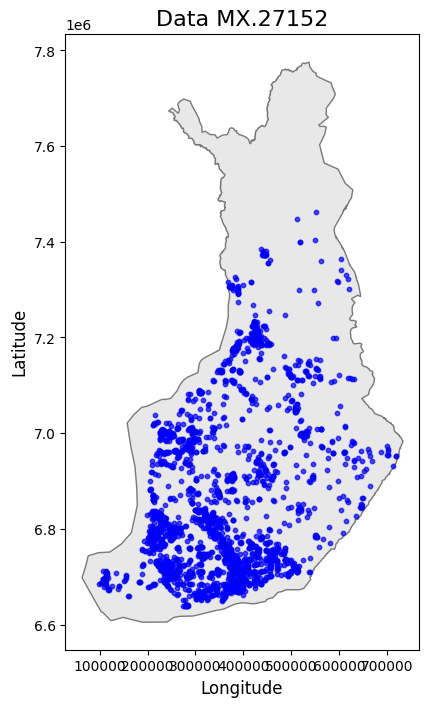

In [5]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the background polygons
borders = gpd.read_file(sample_points_area)
borders.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5, label='Background Polygons')

# Plot the background samples
gdf.plot(
    ax=ax,
    color='blue',  # Use a distinct color
    markersize=10,
    alpha=0.7
)

# Add labels and a title for better clarity
ax.set_title(f'Data {taxon_id}', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Show the plot
plt.show()

## Prepare data

In [6]:
# Enrich data
gdf = helpers.calculate_land_cover_proportions(gdf, corine_path, corine_buffer_size)
gdf = helpers.extract_raster_values(gdf, raster_paths)
gdf = helpers.extract_raster_values_with_buffer(gdf, raster_paths_for_buffer)
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y


gdf = gdf.dropna() 
print(f"After dropping empty values, the GeoDataFrame has {len(gdf)} occurrences. Empty values may be caused due to insufficient raster coverage")

Calculating corine land cover proportions...
Processing raster: data_env/dem.tif
Processing raster: data_env/rain.tif
Processing raster: data_env/temp.tif
Processing raster: data_env/tree_vol.tif with buffer of 100 meters
After dropping empty values, the GeoDataFrame has 3117 occurrences. Empty values may be caused due to insufficient raster coverage


In [7]:
features = gdf[feature_columns]
features = helpers.normalise_columns(features)

## Train and evaluate three different models

1. One Class Support Vector Machine (https://www.geeksforgeeks.org/understanding-one-class-support-vector-machines/)

In [15]:
# Define hyperparameter grid for One-Class SVM
param_grid_svm = {
    'kernel': ['rbf', 'linear', 'poly'],
    'nu': [0.01, 0.05, 0.1, 0.2],  # Fraction of expected anomalies
    'gamma': ['scale', 'auto', 0.1, 1, 10]  # Kernel coefficient
}

# Perform Grid Search with Cross-Validation
svm = OneClassSVM()
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_svm.fit(features)

# Best parameters and model
best_svm = grid_search_svm.best_estimator_
print(f"Best parameters for One-Class SVM: {grid_search_svm.best_params_}")

# Use the best model for prediction
predictions_oneclasssvm = best_svm.fit_predict(features)
anomaly_scores_oneclasssvm = best_svm.decision_function(features)

# Store results
gdf.loc[:,'outlier_oneclassSVM'] = predictions_oneclasssvm
gdf.loc[:,'anomaly_score_oneclassSVM'] = anomaly_scores_oneclasssvm



Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters for One-Class SVM: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}


2. Isolation Forest

In [16]:
# Define hyperparameter grid for Isolation Forest
param_grid_isolation = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.75, 1.0],
    'contamination': ['auto', 0.05, 0.1, 0.2],  # Expected anomaly fraction
    'max_features': [0.5, 0.75, 1.0],
    'random_state': [42]
}

# Perform Grid Search with Cross-Validation
isolation_forest = IsolationForest()
grid_search_isolation = GridSearchCV(isolation_forest, param_grid_isolation, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_isolation.fit(features)

# Best parameters and model
best_isolation_forest = grid_search_isolation.best_estimator_
print(f"Best parameters for Isolation Forest: {grid_search_isolation.best_params_}")

# Use the best model for prediction
predictions_isolf = best_isolation_forest.fit_predict(features)
anomaly_scores_isolf = best_isolation_forest.decision_function(features)

# Store results in the GeoDataFrame
gdf.loc[:,'outlier_isolation_forest'] = predictions_isolf
gdf.loc[:,'anomaly_score_isolation_forest'] = anomaly_scores_isolf

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for Isolation Forest: {'contamination': 'auto', 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 50, 'random_state': 42}


3. N Nearest Neighbors

In [17]:

# Define a range of k values to test
k_range = range(2, min(len(features), 101))  # Cap k to avoid small datasets

best_k = None
best_score_variance = 0
best_anomaly_scores = None

for k in k_range:
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    nearest_neighbors.fit(features)
    distances, _ = nearest_neighbors.kneighbors(features)
    
    # Use the negative mean distance to neighbors as the anomaly score
    anomaly_scores_knn = -np.mean(distances, axis=1)
    
    # Calculate variance of anomaly scores as a measure of separation
    score_variance = np.var(anomaly_scores_knn)
    
    # If this k yields a higher variance in anomaly scores, update best_k
    if score_variance > best_score_variance:
        best_k = k
        best_score_variance = score_variance
        best_anomaly_scores = anomaly_scores_knn

print(f"Best k for k-NN: {best_k}")

# Determine outliers based on a threshold
threshold_knn = np.percentile(best_anomaly_scores, 95)  # Top 5% anomalies
outliers_knn = (best_anomaly_scores > threshold_knn).astype(int)

# Store k-NN results in the GeoDataFrame
gdf.loc[:,'outlier_knn'] = outliers_knn
gdf.loc[:,'anomaly_score_knn'] = best_anomaly_scores

Best k for k-NN: 100


In [18]:
# normalise results
gdf[['anomaly_score_knn', 'anomaly_score_oneclassSVM', 'anomaly_score_isolation_forest']] = helpers.normalise_columns(gdf[['anomaly_score_knn', 'anomaly_score_oneclassSVM', 'anomaly_score_isolation_forest']])

# Calculate the average anomaly score and add it to a new column 'total'
gdf['mean'] = gdf[['anomaly_score_knn', 'anomaly_score_oneclassSVM', 'anomaly_score_isolation_forest']].mean(axis=1)



## Visualise Results

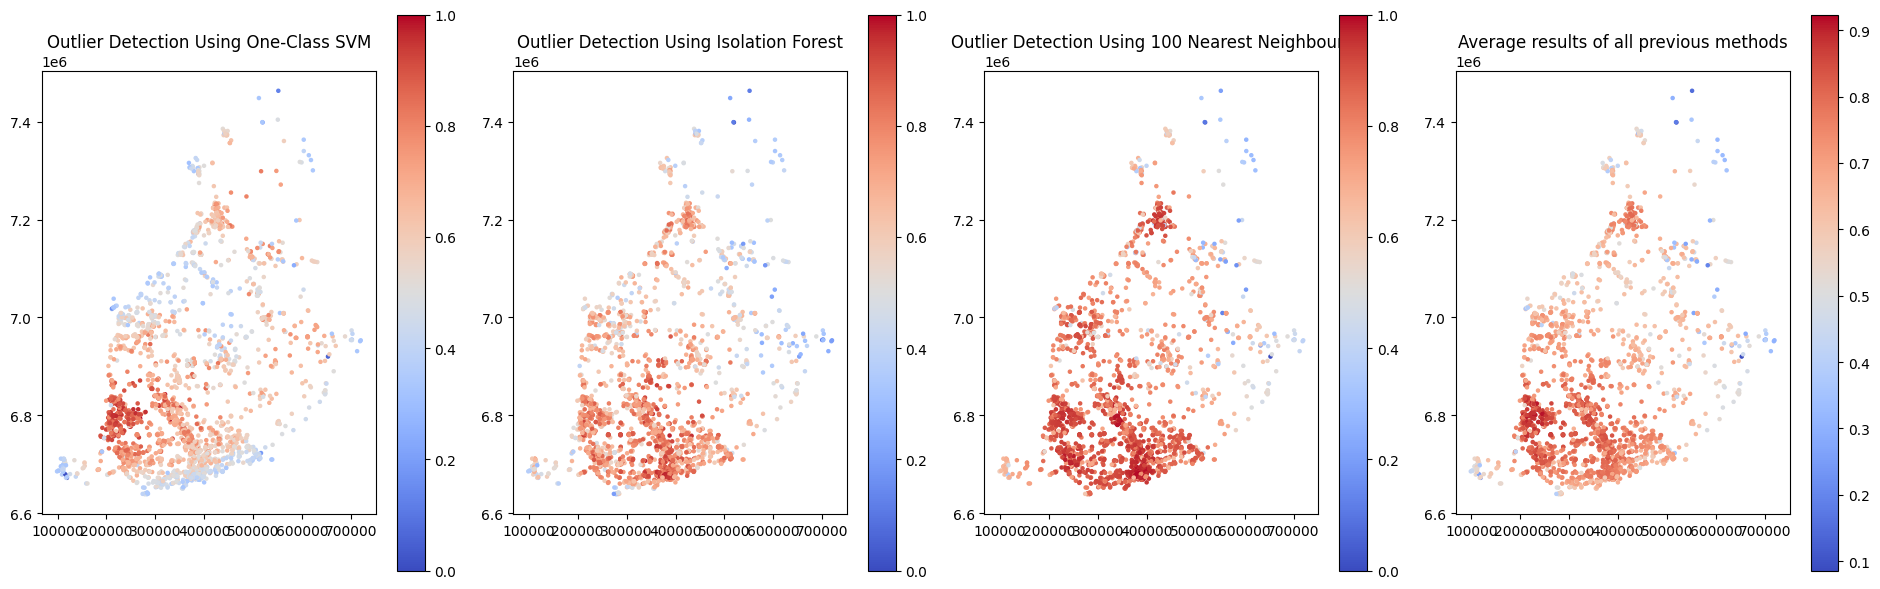

In [19]:
# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axes = plt.subplots(1, 4, figsize=(19, 6))

# Plot the map using the One-Class SVM anomaly scores
gdf.plot(
    column='anomaly_score_oneclassSVM', 
    cmap='coolwarm', 
    legend=True, 
    markersize=5, 
    ax=axes[0]
)
axes[0].set_title('Outlier Detection Using One-Class SVM')

# Plot the map using the Isolation Forest anomaly scores
gdf.plot(
    column='anomaly_score_isolation_forest', 
    cmap='coolwarm', 
    legend=True, 
    markersize=5, 
    ax=axes[1]
)
axes[1].set_title('Outlier Detection Using Isolation Forest')

# Plot the map using the N Nearest Neighbours anomaly scores
gdf.plot(
    column='anomaly_score_knn', 
    cmap='coolwarm', 
    legend=True, 
    markersize=5, 
    ax=axes[2]
)
axes[2].set_title(f'Outlier Detection Using {best_k} Nearest Neighbours')

# Plot the map using the N Nearest Neighbours anomaly scores
gdf.plot(
    column='mean', 
    cmap='coolwarm', 
    legend=True, 
    markersize=5, 
    ax=axes[3]
)
axes[3].set_title(f'Average results of all previous methods')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [12]:
# Save the results
gdf.to_file(output_path, driver='GPKG')